# Forward Model

In [2]:
from __future__ import annotations

import contextlib
import pathlib
import tempfile

import matplotlib.pyplot as plt
import numpy as np

import pymod6.input as mod_input
import pymod6.output
from pymod6.bandmodel import combine_by_k_int

# Setup input file

In [3]:
base_case = mod_input.merge_case_parts(
    mod_input.basecases.BASE_0,
    mod_input.basecases.SPECTRAL_VNIR_SWIR,
    mod_input.make_case(
        RTOPTIONS__MODTRN="RT_CORRK_FAST",
        SPECTRAL__LBMNAM="T",
        SPECTRAL__BMNAME="01_2013",
        SPECTRAL__FWHM=200,
        SPECTRAL__DV=100,
    ),
    allow_override=True,
)
print(base_case)

input_json = (
    mod_input.ModtranInputBuilder()
    .add_template_case(base_case)
    .extend(SURFACE__SURREF=0.0)
    .finish_template()
    .build_json_input(output_legacy=True, binary=True, output_sli=True)
)
print(input_json)

{'RTOPTIONS': {'IEMSCT': <RTExecutionMode.RT_SOLAR_AND_THERMAL: 'RT_SOLAR_AND_THERMAL'>, 'MODTRN': <RTAlgorithm.RT_CORRK_FAST: 'RT_CORRK_FAST'>, 'IMULT': <RTMultipleScattering.RT_DISORT: 'RT_DISORT'>, 'DISALB': True}, 'SURFACE': {'SURFTYPE': <SurfaceType.REFL_CONSTANT: 'REFL_CONSTANT'>, 'SURREF': 1.0}, 'SPECTRAL': {'V1': 4000.0, 'V2': 25000.0, 'DV': 100.0, 'FWHM': 200.0, 'LBMNAM': 'T', 'BMNAME': '01_2013'}}
{'MODTRAN': [{'MODTRANINPUT': {'NAME': 'case0', 'CASE': 0, 'RTOPTIONS': {'IEMSCT': <RTExecutionMode.RT_SOLAR_AND_THERMAL: 'RT_SOLAR_AND_THERMAL'>, 'MODTRN': <RTAlgorithm.RT_CORRK_FAST: 'RT_CORRK_FAST'>, 'IMULT': <RTMultipleScattering.RT_DISORT: 'RT_DISORT'>, 'DISALB': True}, 'SURFACE': {'SURFTYPE': <SurfaceType.REFL_CONSTANT: 'REFL_CONSTANT'>, 'SURREF': 1.0}, 'SPECTRAL': {'V1': 4000.0, 'V2': 25000.0, 'DV': 100.0, 'FWHM': 200.0, 'LBMNAM': 'T', 'BMNAME': '01_2013'}, 'FILEOPTIONS': {'NOFILE': 0, 'BINARY': True, 'CKPRNT': False, 'FLROOT': 'case0', 'SLIPRNT': 'case0', 'JSONPRNT': 'case0.

# Locate MODTRAN Executable

In [4]:
mod_env = pymod6.ModtranEnv.from_shell_file(
    pathlib.Path("~/MIT-LL/MODTRAN/setup_env.sh").expanduser()
)

mod_exec = pymod6.ModtranExecutable(env=mod_env)

# Run simulation and read output files

In [5]:
run_dir_cm = tempfile.TemporaryDirectory()
run_dir_cm = contextlib.nullcontext(None)

with run_dir_cm as work_dir:
    result = mod_exec.run(input_json, work_dir=work_dir)

    if result.process.returncode != 0:
        print(f"WARNING: exit status {result.process.returncode}")
    if "Error" in result.process.stdout:
        print("WARNING: 'Error' found in stdout")
    print(f"{result.cases_output_files.work_dir=}")

    outputs_ref1 = result.cases_output_files[0]
    outputs_ref0 = result.cases_output_files[1]

    acd_data = pymod6.io.read_acd_binary(outputs_ref1.acd_binary)
    sli_data = pymod6.io.read_sli(outputs_ref1.sli_header)

    sli_ref0_data = pymod6.io.read_sli(outputs_ref0.sli_header)

result.cases_output_files.work_dir=PosixPath('/home/brian/MIT-LL/01-RTM/pymod6/notebooks/modtran_runs/run_2024-02-15T07-51-53')


# Display available outputs

In [6]:
print(f"{acd_data.dtype.names=}")
print(f"{list(sli_data.data_vars)=}")
print(f"{acd_data.shape=}")
print(f"{sli_data.wavelength.shape=}")

acd_data.dtype.names=('freq', 'los', 'k_int', 'k_weight', 'sun_gnd_diffuse_transm', 'sun_gnd_obs_direct_transm', 'obs_gnd_embedded_dif_transm', 'obs_gnd_direct_transm', 'spherical_albedo')
list(sli_data.data_vars)=['total transmittance', 'path emission', 'path thermal scat', 'surface emission', 'path multiple scat', 'path single scat', 'ground reflect', 'direct reflect', 'total radiance', 'reference irradiance', 'irradiance at observer', '- nat log path trans', 'directional emissivity', 'top-of-atmosphere irradiance', 'brightness temp']
acd_data.shape=(320481,)
sli_data.wavelength.shape=(21411,)


# Extract outputs into symbolic names

In [7]:
# Confirm wavelength in wavelengths. Convert to wavelength in micrometers for plotting.
assert sli_data.attrs["wavelength units"] == "Wavenumbers"
wavelength = pymod6.unit.Wavenumber(sli_data.wavelength, "cm-1").as_wavelength("um")

# Extract parameters from inputs.
rho_t = rho_b = input_json["MODTRAN"][0]["MODTRANINPUT"]["SURFACE"]["SURREF"]
mu_s = 1  # 1

# Extract Tape7 outputs.
L_M = sli_data["total radiance"]
L_TS = sli_data["direct reflect"]
L_TBD = sli_data["ground reflect"] - L_TS
L_BD = sli_data["path multiple scat"] - sli_ref0_data["path multiple scat"]
L_D = sli_data["path single scat"] + sli_ref0_data["path multiple scat"]
E_s = sli_data["top-of-atmosphere irradiance"]
L_s_star = mu_s * E_s / np.pi

# Extract ACD outputs.
t_dir_down_bm = acd_data["sun_gnd_obs_direct_transm"]
t_diff_down_bm = acd_data["sun_gnd_diffuse_transm"]
t_dir_up_bm = acd_data["obs_gnd_direct_transm"]
t_diff_up_bm = acd_data["obs_gnd_embedded_dif_transm"]

tau_dir_dir_bm = t_dir_down_bm * t_dir_up_bm
tau_dir_diff_bm = t_dir_down_bm * t_diff_up_bm
tau_diff_dir_bm = t_diff_down_bm * t_dir_up_bm
tau_diff_diff_bm = t_diff_down_bm * t_diff_up_bm

S_star_bm = 1 / (1 - rho_b * acd_data["spherical_albedo"])

# Self check correlated-k weights - sum of weights for each band is 1.
np.testing.assert_allclose(
    pymod6.bandmodel.combine_by_k_int(acd_data["k_weight"], acd_data["k_int"]), 1
)

# MODTRAN Radiance Outputs

Text(0.5, 0, 'Wavelength (um)')

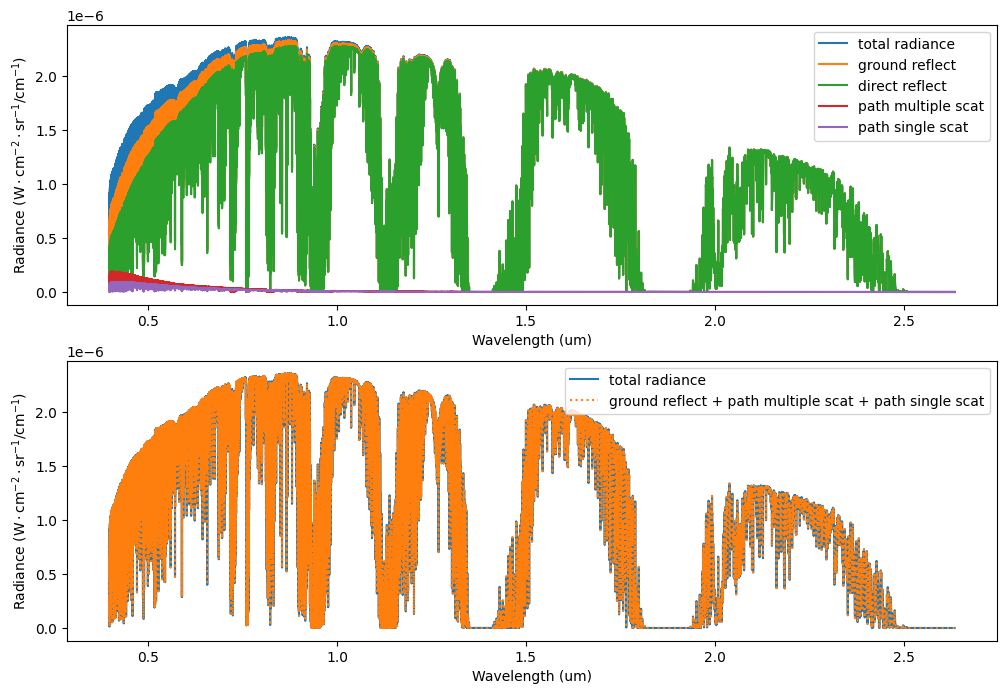

In [26]:
fig, axs = plt.subplots(2, figsize=(12, 8))

for rad_comp in (
    "total radiance",
    "ground reflect",
    "direct reflect",
    "path multiple scat",
    "path single scat",
):
    axs[0].plot(wavelength, sli_data[rad_comp], label=rad_comp)

axs[0].legend()
axs[0].set_xlabel("Wavelength (um)")
axs[0].set_ylabel("Radiance ($\mathrm{W\cdot cm^{-2}\cdot{sr}^{-1}/cm^{-1})}$")

rad_sum = sli_data["ground reflect"] + sli_data["path multiple scat"] + sli_data["path single scat"]
axs[1].plot(wavelength, sli_data["total radiance"], "-", label="total radiance")
axs[1].plot(
    wavelength,
    rad_sum,
    ":",
    label="ground reflect + path multiple scat + path single scat",
)
axs[1].legend()
axs[1].set_ylabel("Radiance ($\mathrm{W\cdot cm^{-2}\cdot{sr}^{-1}/cm^{-1})}$")
axs[1].set_xlabel("Wavelength (um)")

# Construct radiances from ACD outputs / transmittances

In [27]:
L_TS_r = (
    L_s_star
    * rho_t
    * combine_by_k_int(tau_dir_dir_bm * acd_data["k_weight"], acd_data["k_int"])
)
L_TB_r = (
    L_s_star
    * rho_t
    * combine_by_k_int(
        tau_dir_dir_bm * (S_star_bm - 1) * acd_data["k_weight"], acd_data["k_int"]
    )
)
L_TD_r = (
    L_s_star
    * rho_t
    * combine_by_k_int(
        tau_diff_dir_bm * S_star_bm * acd_data["k_weight"], acd_data["k_int"]
    )
)
L_TBD_r = L_TB_r + L_TD_r

L_BD_r = (
    L_s_star
    * rho_b
    * combine_by_k_int(
        (tau_dir_diff_bm + tau_diff_diff_bm) * S_star_bm * acd_data["k_weight"],
        acd_data["k_int"],
    )
)

## Target Direct Reflected

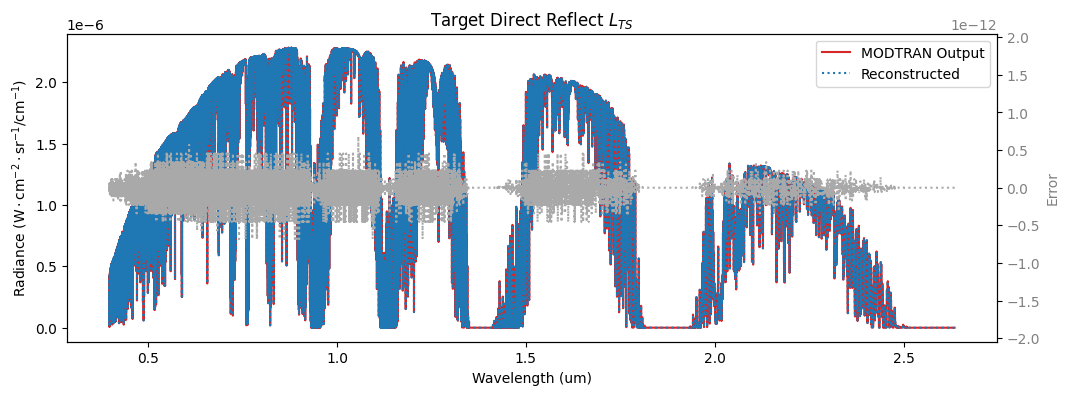

In [59]:
fig, ax = plt.subplots(1, figsize=(12, 4))

ax.plot(wavelength, L_TS, "-", label="MODTRAN Output", color="tab:red")
ax.plot(wavelength, L_TS_r, ":", label="Reconstructed", color="tab:blue")
ax2 = ax.twinx()
L_TS_err = L_TS - L_TS_r
ax2.plot(wavelength, L_TS_err, ":", color="darkgray", label="Error")
ax2.set_ylim(L_TS_err.min() * 3, L_TS_err.max() * 3)
ax2.set_ylabel("Error", color="gray")
ax2.tick_params(axis="y", labelcolor="gray")
ax.set_xlabel("Wavelength (um)")
ax.set_ylabel("Radiance ($\mathrm{W\cdot cm^{-2}\cdot{sr}^{-1}/cm^{-1})}$")
ax.set_title("Target Direct Reflect $L_{TS}$")

ax.legend()
# ax2.legend()

## Target {Direct,Diffuse} Adjacency $L_{TB} + L_{TD}$

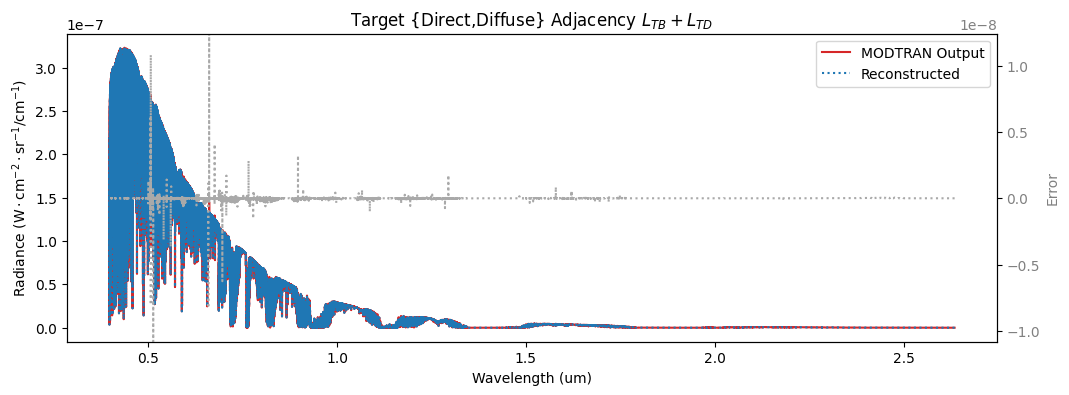

In [58]:
fig, ax = plt.subplots(1, figsize=(12, 4))

ax.plot(wavelength, L_TBD, "-", label="MODTRAN Output", color="tab:red")
ax.plot(wavelength, L_TBD_r, ":", label="Reconstructed", color="tab:blue")
ax2 = ax.twinx()
L_TBD_err = L_TBD - L_TBD_r
ax2.plot(wavelength, L_TBD_err, ":", color="darkgray", label="Error")
ax2.set_ylim(L_TBD_err.min(), L_TBD_err.max())
ax2.set_ylabel("Error", color="gray")
ax2.tick_params(axis="y", labelcolor="gray")
ax.set_xlabel("Wavelength (um)")
ax.set_ylabel("Radiance ($\mathrm{W\cdot cm^{-2}\cdot{sr}^{-1}/cm^{-1})}$")
ax.set_title("Target {Direct,Diffuse} Adjacency $L_{TB} + L_{TD}$")

ax.legend()

## Background Adjacency $L_{BD}$

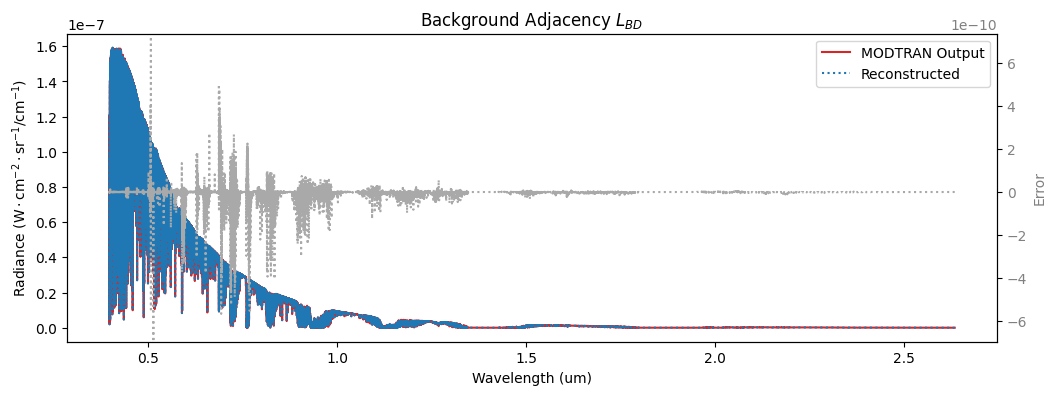

In [57]:
fig, ax = plt.subplots(1, figsize=(12, 4))

ax.plot(wavelength, L_BD, "-", label="MODTRAN Output", color="tab:red")
ax.plot(wavelength, L_BD_r, ":", label="Reconstructed", color="tab:blue")
ax2 = ax.twinx()
L_BD_err = L_BD - L_BD_r
ax2.plot(wavelength, L_BD_err, ":", color="darkgray", label="Error")
ax2.set_ylim(L_BD_err.min(), L_BD_err.max())
ax2.set_ylabel("Error", color="gray")
ax2.tick_params(axis="y", labelcolor="gray")
ax.set_xlabel("Wavelength (um)")
ax.set_ylabel("Radiance ($\mathrm{W\cdot cm^{-2}\cdot{sr}^{-1}/cm^{-1})}$")
ax.set_title("Background Adjacency $L_{BD}$")

ax.legend()

# Total radiance $L_M$

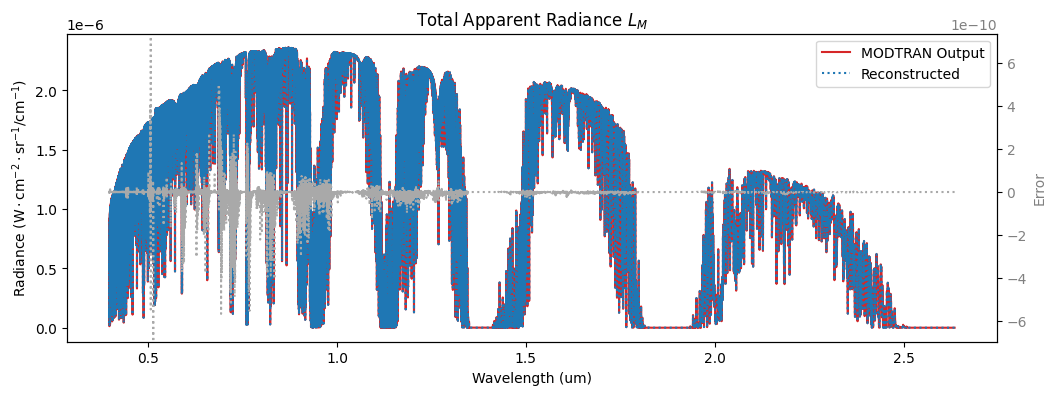

In [56]:
L_M_r = L_TS_r + L_TBD_r + L_BD_r + L_D  # todo reconstruct L_D?

fig, ax = plt.subplots(1, figsize=(12, 4))

ax.plot(wavelength, L_M, "-", label="MODTRAN Output", color="tab:red")
ax.plot(wavelength, L_M_r, ":", label="Reconstructed", color="tab:blue")
ax2 = ax.twinx()
L_M_err = L_M - L_M_r
ax2.plot(wavelength, L_BD_err, ":", color="darkgray", label="Error")
ax2.set_ylim(L_BD_err.min(), L_BD_err.max())
ax2.set_ylabel("Error", color="gray")
ax2.tick_params(axis="y", labelcolor="gray")
ax.set_xlabel("Wavelength (um)")
ax.set_ylabel("Radiance ($\mathrm{W\cdot cm^{-2}\cdot{sr}^{-1}/cm^{-1})}$")
ax.set_title("Total Apparent Radiance $L_{M}$")

ax.legend()